In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pickle
import torch
from jointset import jointset
from vmse import vmse
from resnet import resnet, resnet34, resnet18
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dir = "./data/train2017"
#train_dir = "/datasets/coco/coco_train2014"
train_a_path = "./data/annotations/person_keypoints_train2017.json"
#train_a_path = "/datasets/coco/annotations/person_keypoints_train2014.json"
val_dir = "./data/val2017"
#val_dir = "/datasets/coco/coco_val2014"
val_a_path ="./data/annotations/person_keypoints_val2017.json"
#val_a_path ="/datasets/coco/annotations/person_keypoints_val2014.json" 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(), normalize])
#train_data = jointset(train_dir,train_a_path,True, transform)
val_data = jointset(val_dir,val_a_path,False, transform)
#train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle= False)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet34()
model.to(device)
model.eval()
criterion = vmse()
optimizer = torch.optim.Adam(model.parameters())
checkpoint_f = "./checkpoints/model34.pt"
checkpoint = torch.load(checkpoint_f)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: './model34.pt'

In [ ]:
def denormalize_coords(pts,bw=192,bh=256,bc = (96,128)):
        pts[:,0]*= bw
        pts[:,1]*=bh
        pts[:,0]+=bc[0]
        pts[:,1]+=bc[1]
        return pts
def normalize_coords(pts, bw=192,bh=256,bc = (96,128)):
    pts[:,0] = (pts[:,0] - bc[0])/bw
    pts[:,1] = (pts[:,1] - bc[1])/bh
    return pts

In [54]:
pts = np.array([[10,10],[20,20],[30,30],[40,40]]).astype(float)
model_state_dict
a = normalize_coords(pts)
print(a)
b = denormalize_coords(a)
print(b)

[[-0.44791667 -0.4609375 ]
 [-0.39583333 -0.421875  ]
 [-0.34375    -0.3828125 ]
 [-0.29166667 -0.34375   ]]
[[10. 10.]
 [20. 20.]
 [30. 30.]
 [40. 40.]]


torch.Size([1, 3, 256, 192])
PCK 0.6470588235294118
torch.Size([1, 3, 256, 192])
PCK 0.9411764705882353
torch.Size([1, 3, 256, 192])


/home/warren/mlenv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


PCK 0.11764705882352941
torch.Size([1, 3, 256, 192])
PCK 0.7058823529411765
torch.Size([1, 3, 256, 192])
PCK 0.6470588235294118
torch.Size([1, 3, 256, 192])
PCK 1.0
torch.Size([1, 3, 256, 192])
PCK 0.8823529411764706
torch.Size([1, 3, 256, 192])
PCK 0.8235294117647058
torch.Size([1, 3, 256, 192])
PCK 0.8823529411764706
torch.Size([1, 3, 256, 192])
PCK 0.8823529411764706


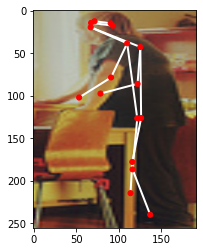

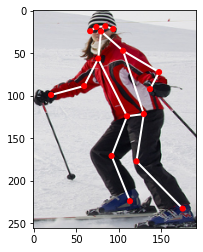

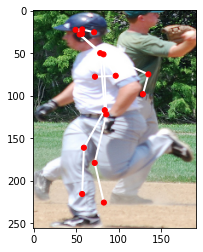

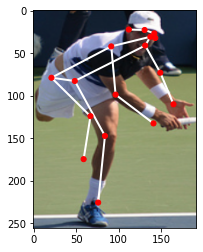

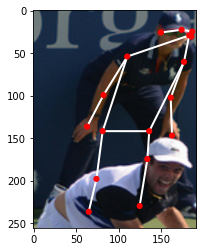

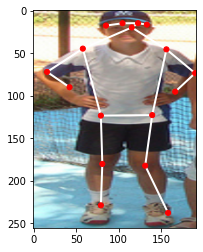

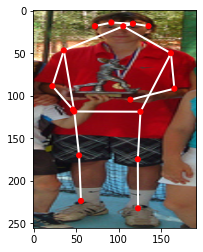

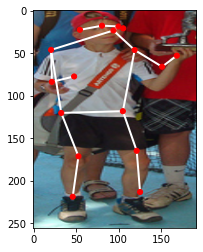

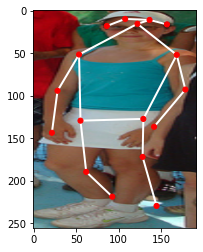

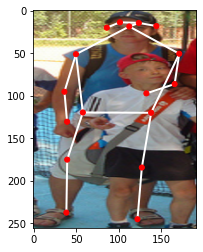

In [5]:
model.eval()
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from utils import eval_PCK, plotoverlay
count =0 
with torch.no_grad():
    for idx, data in enumerate(val_loader,0):
        inputs, labels, visibility, orig= data
        print(inputs.shape)
        inputs = inputs.to(device)
        labels = labels.to(device)
        visibility = visibility.to(device)
        labels = labels.type(torch.float32) #did this bc of error of found dtype double but expected float
        outputs = model(inputs)
        img = orig.squeeze().detach().cpu().numpy()
        outputs = outputs.squeeze().detach().cpu().numpy().astype(np.float32)
        labels = labels.squeeze().detach().cpu().numpy().astype(np.float32)
        labels = denormalize_coords(labels)
        outputs = denormalize_coords(outputs, 192, 256, (96,128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plotoverlay(outputs, img)
        print("PCK",eval_PCK(outputs,labels))
        count+=1
        if count == 10:
            break


In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import cv2
im = cv2.imread("golf.jpg")
ishape = im.shape 
ishape = im.shape 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 192])


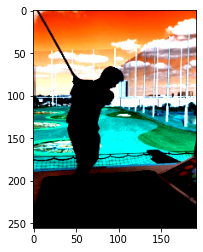

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
resize = transforms.Resize((256,192))
transform = transforms.Compose([resize, transforms.ToTensor(), normalize])

pil_im = Image.fromarray(np.uint8(im))
t = transform(pil_im)
print(t.shape)
plt.imshow(t.permute(1,2,0))

In [12]:
ex = t.unsqueeze(dim=0).to(device)
print(ex.shape)

torch.Size([1, 3, 256, 192])


In [13]:
preds = model(ex)
print(preds.shape)

torch.Size([1, 17, 2])


In [14]:
preds = preds.squeeze().detach().cpu().numpy().astype(np.float32)
print(preds)
preds = denormalize_coords(preds, 192, 256, (96,128))

[[ 16.714464   -5.881213 ]
 [  1.5118307   3.403591 ]
 [ -2.569968   33.422993 ]
 [  2.9948037  19.725172 ]
 [-15.729847  -10.591461 ]
 [  9.605893   27.448513 ]
 [ -3.948001   -4.624167 ]
 [ 15.413345    3.2553804]
 [-24.074083    7.246399 ]
 [ -6.396098   -4.6058235]
 [-17.347948   -2.836031 ]
 [  8.817621  -12.824657 ]
 [ 21.66022    10.776881 ]
 [  3.9503717  -7.711367 ]
 [ 31.470484    8.93235  ]
 [ -9.026457   -7.8421993]
 [ -5.3392925  -4.127414 ]]


NameError: name 'denormalize_coords' is not defined

In [9]:
from utils import plotoverlay

im2 = np.array(pil_im.resize((192,256)))
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plotoverlay(preds, im2)


None


In [20]:
def recenter_coords(pts,orig_shape):
    pts[:,0]*= orig_shape[1]/192
    pts[:,1]*= orig_shape[0]/256
    return pts
pred_rc = recenter_coords(preds, ishape)

In [10]:

im = cv2.imread("golf.jpg")
plotoverlay(list(pred_rc),im)


NameError: name 'pred_rc' is not defined

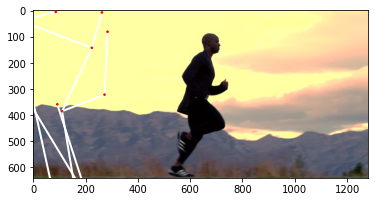

In [31]:
from utils import plotoverlay
im = cv2.imread('run_jpgs/ss036.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plotoverlay(list(i_pred[0]),im)

In [32]:
print(i_pred[0])

[[ 419.19238   2251.885    ]
 [ 210.66232    724.2874   ]
 [ -10.025513   359.38312  ]
 [  92.18548    358.5821   ]
 [  -7.564743   382.91388  ]
 [ -31.840775   204.93533  ]
 [ 110.46538    385.02536  ]
 [ -78.46434    170.30807  ]
 [ 272.59073    321.47235  ]
 [ -81.06586     40.5953   ]
 [ 284.28052     80.935745 ]
 [ -48.713486    39.59548  ]
 [ 224.14735    142.46411  ]
 [  86.08653      5.0550995]
 [ 262.8154       7.3575897]
 [ 141.00922    -94.09709  ]
 [ 288.1048    -103.65132  ]]
